In [52]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [53]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Num GPUs Available:  0
cuda


In [54]:
num_epochs = 20
batchsize = 24
learning_rate = 0.0001
optimizer = "adam"
future_window_size = 12
past_window_size = 10
weight_decay = 0.001

encoder_latent_vector = 300
decoder_latent_vector = 300

episodes = 540
train_folder = "3dmodel/test_4_episode_"
len_seq = 60
seq_per_ep = 6

In [55]:
# Normalize pitch and roll angles
def norm_pr(x, min = -90.0, max = 90.0):
    return ((x - min) * 2) / (max - min) - 1

In [56]:
# load index to get correct data from dataloader
def load_labels(seq_per_ep=6, start_ep=0, end_ep=540, p_train=0.7, p_val=0.15):
   
    random.seed(13)

    # create index array from start_ep to end_ep, evenly spaced
    # (start, end, amount of steps to get from start to end, type)
    # [0, 1, 2, ..., 3240]
    all_ep = np.linspace(
        start_ep*seq_per_ep,    
        end_ep*seq_per_ep, 
        (end_ep*seq_per_ep - start_ep*seq_per_ep + 1),     
        dtype =int 
    )

    train_labels = np.array([], dtype =int)
    val_labels = np.array([], dtype =int)
    test_labels = np.array([], dtype =int)

    tmp_num = 60
    
    # 540*6/60 = 54
    window = int((len(all_ep))/tmp_num) 

    for episode in range(tmp_num):

        tmp_ep = all_ep[episode*window : (episode+1)*window]
        len_tmp_ep = tmp_ep.size

        random.shuffle(tmp_ep)
        
        # [start : stop : step]
        # first 70% data
        train_labels = np.concatenate(
            (train_labels, tmp_ep[0 : int(p_train*len_tmp_ep)] ))
        # next 15% data 
        val_labels = np.concatenate(
            (val_labels, tmp_ep[int(p_train*len_tmp_ep) : int((p_train+p_val)*len_tmp_ep)] ))      
        # final 15% data
        test_labels = np.concatenate(
            (test_labels, tmp_ep[int((p_train+p_val)*len_tmp_ep): ] ))

    train_labels = np.concatenate((train_labels, all_ep[tmp_num*window:]))

    random.shuffle(train_labels)
    random.shuffle(val_labels)
    random.shuffle(test_labels)

    return train_labels, val_labels, test_labels

In [57]:
# load data
train_labels, val_labels, test_labels = load_labels()

print('len(train_labels) -> ', len(train_labels))
print('len(val_labels) -> ', len(val_labels))
print('len(test_labels) -> ', len(test_labels))

len(train_labels) ->  2221
len(val_labels) ->  480
len(test_labels) ->  540


In [58]:
filename = "../3dmodel/test_4_episode_1/labels_0.json"
data = []
labels = json.load(open(filename))
ep1 = pd.DataFrame(labels)
ep1 = ep1.transpose()
ep1.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
ep1

,pitch,roll
0,15.915869,2.358416
1,14.295925,1.700391
2,6.213590,1.611325
3,1.235337,6.175461
4,1.341678,3.695468
...,...,...
395,-0.204481,1.503337
396,1.074743,10.724272
397,13.373594,1.542949
398,11.193637,-0.848632


<AxesSubplot:>

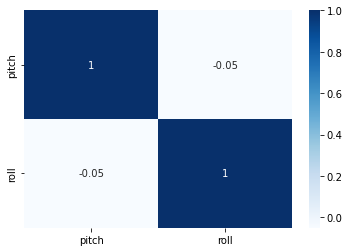

In [59]:
corr = ep1.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

In [60]:
# load the data
n_episodes = 540
pr = []
episodes = []
for ep in range(1, n_episodes+1):
    filename = "../3dmodel/test_4_episode_"+ str(ep) +"/labels_0.json"
    labels = json.load(open(filename))
    for i in labels:
        pr.append(labels[i])
        episodes.append(labels[i]+[ep, i])

In [61]:
df = pd.DataFrame(episodes)
df.rename(columns = {0:'pitch', 1:'roll', 2:'episode', 3:'position_within_episode'}, inplace=True)
df = df.astype({"pitch": float, "roll": float})
df

,pitch,roll,episode,position_within_episode
0,15.915869,2.358416,1,0
1,14.295925,1.700391,1,1
2,6.213590,1.611325,1,2
3,1.235337,6.175461,1,3
4,1.341678,3.695468,1,4
...,...,...,...,...
215995,0.428497,-0.663964,540,395
215996,0.485498,-1.376229,540,396
215997,-0.658033,-1.328761,540,397
215998,-1.322262,-1.650465,540,398


<AxesSubplot:>

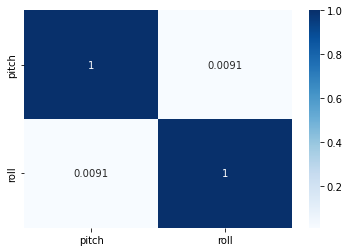

In [62]:
corr = df[['pitch','roll']].corr()
sns.heatmap(corr, cmap="Blues", annot=True)

In [63]:
df2 = df.copy()
df2["pr"] = list(zip(df["pitch"].round(2), df["roll"].round(2)))
df2.drop(columns=["pitch","roll"], axis=0, inplace=True)
df2 = df2[["pr","episode","position_within_episode"]]
df2

,pr,episode,position_within_episode
0,"(15.92, 2.36)",1,0
1,"(14.3, 1.7)",1,1
2,"(6.21, 1.61)",1,2
3,"(1.24, 6.18)",1,3
4,"(1.34, 3.7)",1,4
...,...,...,...
215995,"(0.43, -0.66)",540,395
215996,"(0.49, -1.38)",540,396
215997,"(-0.66, -1.33)",540,397
215998,"(-1.32, -1.65)",540,398


In [64]:
df2.dtypes

pr                         object
episode                     int64
position_within_episode    object
dtype: object

In [65]:
rows = df2.groupby('episode')['pr'].apply(list)
df_stack = pd.DataFrame(rows)
df_stack.reset_index()

,episode,pr
0,1,"[(15.92, 2.36), (14.3, 1.7), (6.21, 1.61), (1...."
1,2,"[(15.98, 2.27), (9.86, 1.36), (6.11, 1.56), (1..."
2,3,"[(15.96, 2.07), (6.18, 0.12), (6.08, 1.68), (1..."
3,4,"[(7.7, 1.58), (8.48, 0.06), (3.16, 0.86), (1.0..."
4,5,"[(7.81, 1.49), (7.87, 0.18), (3.13, 0.91), (0...."
...,...,...
535,536,"[(27.03, -7.86), (19.12, -5.18), (12.65, -3.41..."
536,537,"[(18.02, -5.29), (18.95, -5.79), (10.58, -2.69..."
537,538,"[(21.82, -6.14), (14.1, -3.58), (9.7, -2.57), ..."
538,539,"[(21.23, -6.12), (16.44, -4.69), (10.11, -2.68..."


In [66]:
# normalize PR-values
df['pitch'] = df['pitch'].apply(lambda x : norm_pr(x))
df['roll'] = df['roll'].apply(lambda x : norm_pr(x))
df

,pitch,roll,episode,position_within_episode
0,0.176843,0.026205,1,0
1,0.158844,0.018893,1,1
2,0.069040,0.017904,1,2
3,0.013726,0.068616,1,3
4,0.014908,0.041061,1,4
...,...,...,...,...
215995,0.004761,-0.007377,540,395
215996,0.005394,-0.015291,540,396
215997,-0.007311,-0.014764,540,397
215998,-0.014692,-0.018338,540,398


In [67]:
# normalize episode number and position within episode
scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(df[["episode", "position_within_episode"]])
df[["episode", "position_within_episode"]] = scaler.transform(df[["episode", "position_within_episode"]])
df

,pitch,roll,episode,position_within_episode
0,0.176843,0.026205,-1.0,-1.000000
1,0.158844,0.018893,-1.0,-0.994987
2,0.069040,0.017904,-1.0,-0.989975
3,0.013726,0.068616,-1.0,-0.984962
4,0.014908,0.041061,-1.0,-0.979950
...,...,...,...,...
215995,0.004761,-0.007377,1.0,0.979950
215996,0.005394,-0.015291,1.0,0.984962
215997,-0.007311,-0.014764,1.0,0.989975
215998,-0.014692,-0.018338,1.0,0.994987


In [68]:
TRAIN_SIZE = 0.8
train_size = int(len(df) * TRAIN_SIZE)
train_size

172800

In [69]:
train_df, test_df = df[:train_size], df[train_size+1:]
train_df.shape, test_df.shape

((172800, 4), (43199, 4))

In [70]:
# divide into sequences 
X = []
y = []
for x in range(len(pr)-past_window_size):
    window = [x for x in pr[x:x+past_window_size]]
    X.append(window)
    y.append(pr[x+past_window_size])

episodes = np.array(episodes)
pr = np.array(pr)
X = np.array(X)
y = np.array(y)
pr.shape, episodes.shape, X.shape, y.shape

((216000, 2), (216000, 4), (215990, 10, 2), (215990, 2))

In [71]:
X_train, y_train = X[:140000], y[:140000]
X_val, y_val = X[140000:180000], y[140000:180000]
X_test, y_test = X[180000:], y[180000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((140000, 10, 2),
 (140000, 2),
 (40000, 10, 2),
 (40000, 2),
 (35990, 10, 2),
 (35990, 2))

In [72]:
# function to create sequences with one target column
def create_sequences(input_data: pd.DataFrame, target_column, sequence_length):
    sequences= []
    data_size = len(input_data)

    for i in tqdm(range(data_size - sequence_length)):

        sequence = input_data[i:i+sequence_length]

        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]

        sequences.append((sequence, label))

    return sequences

In [73]:
SEQUENCE_LENGTH = 30
train_sequences = create_sequences(train_df, "pitch", SEQUENCE_LENGTH)
test_sequences = create_sequences(test_df, "pitch", SEQUENCE_LENGTH)

  0%|          | 0/172770 [00:00<?, ?it/s]

  0%|          | 0/43169 [00:00<?, ?it/s]

In [74]:
train_sequences[0][0].shape, test_sequences[0][0].shape

((30, 4), (30, 4))

## Pytorch Dataset

In [75]:
class PRDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence, label = self.sequences[index]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).float()
        )

In [76]:
class PRDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batchsize = 8):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batchsize = batchsize

    def setup(self):
        self.train_dataset = PRDataset(self.train_sequences)
        self.test_dataset = PRDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=16,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=16,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=16,
        )

In [77]:
NUM_EPOCHS = 8
BATCH_SIZE = 64

data_module = PRDataModule(train_sequences, test_sequences, BATCH_SIZE)
data_module.setup()

In [78]:
train_dataset = PRDataset(train_sequences)

In [79]:
for item in train_dataset:
    print(item["sequence"].shape)
    print(item["label"].shape)
    print(item["label"])
    break


torch.Size([30, 4])
torch.Size([])
tensor(0.0972)


## LSTM Model

In [80]:
class PRPredictionModel(nn.Module):
    def __init__(self, n_features, n_hidden=128, n_layers=2):
        super().__init__()

        self.n_hidden = n_hidden

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            batch_first=True,
            num_layers=n_layers,
            dropout=0.2
        )

        self.regressor = nn.Linear(n_hidden, 1)

    def forward(self, x):
        self.lstm.flatten_parameters()
    
        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]

        return self.regressor(out)

In [81]:
class PRPredictor(pl.LightningModule):
    def __init__(self, n_features: int): 
        super().__init__()

        self.model = PRPredictionModel(n_features)
        self.criterion = nn.MSELoss()

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))

        return loss, output
    
    def training_step(self, batch, batch_index):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)

        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_index):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)

        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_index):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=0.0001)

In [82]:
model = PRPredictor(n_features=train_df.shape[1])

In [83]:
data_module_train_dataloader = data_module.train_dataloader()

In [84]:
"""
for item in data_module_train_dataloader:
    print(item["sequence"].shape)
    print(item["label"].shape)
    break
"""

'\nfor item in data_module_train_dataloader:\n    print(item["sequence"].shape)\n    print(item["label"].shape)\n    break\n'

In [85]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs


Reusing TensorBoard on port 6006 (pid 16948), started 9:13:41 ago. (Use '!kill 16948' to kill it.)

In [86]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="PR-prediction")

early_stopping_callback = EarlyStopping(monitor="val_loss", patience=2)

trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping_callback],
    max_epochs = NUM_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

C:\src\Anaconda\envs\ML env\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x000002CECE30E8B0>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x000002CECE30E8B0>)`.
  rank_zero_deprecation(
C:\src\Anaconda\envs\ML env\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True

In [87]:
pl.__version__

'1.5.10'

In [88]:
trainer.fit(model, data_module)

C:\src\Anaconda\envs\ML env\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | PRPredictionModel | 200 K 
1 | criterion | MSELoss           | 0     
------------------------------------------------
200 K     Trainable params
0         Non-trainable params
200 K     Total params
0.803     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
class LSTM_PR(nn.Module):
    def __init__(self, cuda, encoder_input_size, output_size, encoder_hidden_size=300, decoder_hidden_size=300): 
        super(LSTM_PR, self).__init__()
        self.cuda_p = cuda
        
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size

         # (input size, hidden size, num_layers)
        self.encoder_lstm = nn.LSTM(encoder_input_size, encoder_hidden_size, batch_first=True)
        self.decoder_lstm = nn.LSTM(decoder_hidden_size, decoder_hidden_size, batch_first=True)

        # (in_features, out_features)
        self.decoder_fc_1 = nn.Linear(decoder_hidden_size, int(decoder_hidden_size/2))
        self.decoder_fc_2 = nn.Linear(int(decoder_hidden_size/2), output_size)
    
    def forward(self, pr, use_n_pr, predict_n_pr, encoder_hidden, decoder_hidden):
        PR  = [pr[i] for i in range(use_n_pr)]

        lstm_input_features = torch.cat(PR, 1).view(pr[0].size(0), 1, -1)

        encoder_output, encoder_hidden = self.LSTM_encoder(lstm_input_features,  encoder_hidden)
        decoder_output, decoder_hidden = self.LSTM_decoder(encoder_output, decoder_hidden)

        decoder_output = decoder_output.view(pr[0].size(0), predict_n_pr, -1)

        return decoder_output, encoder_hidden, decoder_hidden


